In [1]:
# 1. InternVL3-8B Non-Quantized Setup - OFFICIAL MULTI-GPU APPROACH
# Testing official InternVL3 multi-GPU device mapping from documentation

# Enable autoreload for module changes
%load_ext autoreload
%autoreload 2

# Standard library imports
import sys
import warnings
from datetime import datetime
from pathlib import Path

# Add current directory to path to ensure proper module resolution
notebook_dir = Path.cwd()
if str(notebook_dir) not in sys.path:
    sys.path.insert(0, str(notebook_dir))

# Third-party imports
import numpy as np
import pandas as pd
import torch
from IPython.display import display
from rich import print as rprint
from rich.console import Console

# Project-specific imports - Using official approach
from common.batch_analytics import BatchAnalytics
from common.batch_processor import BatchDocumentProcessor
from common.batch_reporting import BatchReporter
from common.batch_visualizations import BatchVisualizer
from common.evaluation_metrics import load_ground_truth
from common.extraction_parser import discover_images
from common.internvl3_8b_memory_optimizer import load_internvl3_8b_optimized
from models.document_aware_internvl3_processor import (
    DocumentAwareInternVL3HybridProcessor,
)

print("✅ All imports loaded successfully")
print("🔬 TESTING: OFFICIAL InternVL3 multi-GPU approach")
print("📖 Based on: https://internvl.readthedocs.io/en/latest/internvl3.0/quick_start.html")
print("🎯 Goal: Proper device mapping using official split_model() strategy")
print("🛠️ Approach: Vision model + embeddings on GPU 0, layers distributed across GPUs")
print(f"📂 Working directory: {notebook_dir}")
warnings.filterwarnings('ignore')

✅ All imports loaded successfully
🔬 TESTING: OFFICIAL InternVL3 multi-GPU approach
📖 Based on: https://internvl.readthedocs.io/en/latest/internvl3.0/quick_start.html
🎯 Goal: Proper device mapping using official split_model() strategy
🛠️ Approach: Vision model + embeddings on GPU 0, layers distributed across GPUs
📂 Working directory: /home/jovyan/nfs_share/tod/LMM_POC


In [2]:
# 2. GPU Assessment and Official Multi-GPU Setup
# Check available GPUs and apply official InternVL3 requirements

from common.internvl3_8b_memory_optimizer import InternVL3_8B_MemoryManager

# Check GPU configuration
world_size = torch.cuda.device_count()
rprint(f"[bold cyan]🔍 GPU Configuration Assessment[/bold cyan]")
rprint(f"[cyan]Available GPUs: {world_size}[/cyan]")

if world_size >= 2:
    total_memory = sum(torch.cuda.get_device_properties(i).total_memory / 1e9 for i in range(world_size))
    rprint(f"[cyan]Total GPU Memory: {total_memory:.1f}GB across {world_size} GPUs[/cyan]")
    for i in range(world_size):
        memory = torch.cuda.get_device_properties(i).total_memory / 1e9
        name = torch.cuda.get_device_properties(i).name
        rprint(f"[cyan]  GPU {i}: {name} ({memory:.1f}GB)[/cyan]")
    
    rprint("[green]✅ Multi-GPU setup detected - using official device mapping[/green]")
    rprint("[cyan]📖 Official strategy: ViT + embeddings on GPU 0, layers distributed[/cyan]")
else:
    memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    name = torch.cuda.get_device_properties(0).name
    rprint(f"[yellow]⚠️ Single GPU: {name} ({memory:.1f}GB)[/yellow]")
    rprint("[yellow]💡 Official docs recommend 3x80GB GPUs for non-quantized 8B[/yellow]")

rprint("[bold red]🧹 MEMORY CLEANUP FOR INTERNVL3-8B[/bold red]")

# Initialize memory manager and perform cleanup
memory_manager = InternVL3_8B_MemoryManager(verbose=True)
memory_manager.aggressive_cleanup_for_8b()

# Create initial memory checkpoint
initial_checkpoint = memory_manager.create_memory_checkpoint("notebook_start")

rprint("[green]✅ Memory cleanup complete - ready for official InternVL3-8B loading[/green]")
rprint("[dim]📋 Next: Load model using official multi-GPU device mapping[/dim]")

🔍 GPU Configuration Assessment

Available GPUs: 2

Total GPU Memory: 95.6GB across 2 GPUs

  GPU 0: NVIDIA L40S (47.8GB)

  GPU 1: NVIDIA L40S (47.8GB)

✅ Multi-GPU setup detected - using official device mapping

📖 Official strategy: ViT + embeddings on GPU 0, layers distributed

🧹 MEMORY CLEANUP FOR INTERNVL3-8B

🧹 Performing aggressive cleanup for InternVL3-8B...

🚨 Running V100 emergency GPU cleanup...
🧹 Starting V100-optimized GPU memory cleanup...
   📊 Initial GPU memory: 0.00GB allocated, 0.00GB reserved
   ✅ Final GPU memory: 0.00GB allocated, 0.00GB reserved
   💾 Memory freed: 0.00GB
✅ V100-optimized memory cleanup complete
✅ V100 emergency cleanup complete


🔄 Cleanup round 1/3

🔄 Cleanup round 2/3

🔄 Cleanup round 3/3

☢️ Attempting complete memory pool reset...
✅ Memory pool reorganization attempted
🔧 Final state: Allocated=0.00GB, Reserved=0.02GB, Fragmentation=0.02GB
🧹 Memory state: Allocated=0.00GB, Reserved=0.00GB, Fragmentation=0.00GB


✅ Cleanup complete. Available memory: 89.04GB

📊 Memory checkpoint (notebook_start): 0.00GB allocated, 89.04GB available

✅ Memory cleanup complete - ready for official InternVL3-8B loading

📋 Next: Load model using official multi-GPU device mapping

In [ ]:
# 3. Configuration - InternVL3-8B Non-Quantized Settings
# Initialize console and environment configuration

console = Console()

# Environment-specific base paths
ENVIRONMENT_BASES = {
    'sandbox': '/home/jovyan/nfs_share/tod',
    'efs': '/efs/shared/PoC_data'
}
base_data_path = ENVIRONMENT_BASES['sandbox']

CONFIG = {
    # Model settings - CRITICAL: InternVL3-8B path
    'MODEL_PATH': '/home/jovyan/nfs_share/models/InternVL3-8B',
    # 'MODEL_PATH': '/efs/shared/PTM/InternVL3-8B',
    
    # Batch settings
    'DATA_DIR': f'{base_data_path}/evaluation_data',
    'GROUND_TRUTH': f'{base_data_path}/evaluation_data/ground_truth.csv',
    'OUTPUT_BASE': f'{base_data_path}/output',
    'MAX_IMAGES': None,  # None for all, or set limit for testing
    'DOCUMENT_TYPES': None,  # None for all, or ['invoice', 'receipt']
    'ENABLE_MATH_ENHANCEMENT': False,  # Disable mathematical correction for bank statements
    
    # Inference and evaluation mode
    'INFERENCE_ONLY': False,  # Set to True for inference-only mode
    
    # Verbosity control
    'VERBOSE': True,
    'SHOW_PROMPTS': True,
    
    # InternVL3-8B optimization settings - NON-QUANTIZED with MEMORY OPTIMIZATION
    'USE_QUANTIZATION': False,  # TESTING: Non-quantized with memory optimization
    'DEVICE_MAP': 'auto',
    'MAX_NEW_TOKENS': 600,
    'TORCH_DTYPE': 'float16',  # V100-compatible (changed from bfloat16)
    'LOW_CPU_MEM_USAGE': True,
    # Flash Attention: V100 compatible setting
    'USE_FLASH_ATTN': False  # V100 compatible default
}

# Make GROUND_TRUTH conditional based on INFERENCE_ONLY mode
if CONFIG['INFERENCE_ONLY']:
    CONFIG['GROUND_TRUTH'] = None

# ============================================================================
# PROMPT CONFIGURATION - Explicit file and key mapping
# ============================================================================
# This configuration controls which prompt files and keys are used for each
# document type. You can explicitly override both the file and the key.
#
# Structure:
#   'extraction_files': Maps document types to YAML prompt files
#   'extraction_keys': (Optional) Maps document types to specific keys in those files
#
# If 'extraction_keys' is not specified for a document type, the key will be
# derived from the document type name (e.g., 'INVOICE' -> 'invoice')
#
# For bank statements, structure classification (_flat or _date_grouped) is 
# automatically appended UNLESS you provide a full key in 'extraction_keys'
# ============================================================================

PROMPT_CONFIG = {
    # Document type detection configuration
    'detection_file': 'prompts/document_type_detection.yaml',
    'detection_key': 'detection',
    
    # Extraction prompt file mapping (REQUIRED)
    'extraction_files': {
        'INVOICE': 'prompts/internvl3_prompts.yaml',
        'RECEIPT': 'prompts/internvl3_prompts.yaml', 
        'BANK_STATEMENT': 'prompts/internvl3_prompts.yaml'
    },
    
    # Extraction prompt key mapping (OPTIONAL - for explicit control)
    # Uncomment and configure to override automatic key derivation
    # 'extraction_keys': {
    #     'INVOICE': 'invoice',
    #     'RECEIPT': 'receipt',
    #     'BANK_STATEMENT': 'bank_statement',  # Will auto-append _flat or _date_grouped
    #     # Or specify full key to skip automatic structure suffix:
    #     # 'BANK_STATEMENT': 'bank_statement_flat',  # Forces flat table prompt
    # }
}

# Example configurations:
# ----------------------
# Use generated prompts (if you create InternVL3 generated versions):
#   'extraction_files': {
#       'INVOICE': 'prompts/generated/internvl3_invoice_prompt.yaml',
#       'RECEIPT': 'prompts/generated/internvl3_receipt_prompt.yaml',
#       'BANK_STATEMENT': 'prompts/generated/internvl3_bank_statement_prompt.yaml'
#   }
#
# Mix standard and custom prompts:
#   'extraction_files': {
#       'INVOICE': 'prompts/internvl3_prompts.yaml',
#       'RECEIPT': 'prompts/custom_receipt_prompt.yaml',
#       'BANK_STATEMENT': 'prompts/internvl3_prompts.yaml'
#   }
#
# Force specific bank statement structure:
#   'extraction_keys': {
#       'BANK_STATEMENT': 'bank_statement_flat'  # Ignores vision classification
#   }

# Field list required for DocumentAwareInternVL3HybridProcessor
UNIVERSAL_FIELDS = [
    "DOCUMENT_TYPE", "BUSINESS_ABN", "SUPPLIER_NAME", "BUSINESS_ADDRESS",
    "PAYER_NAME", "PAYER_ADDRESS", "INVOICE_DATE", "STATEMENT_DATE_RANGE",
    "LINE_ITEM_DESCRIPTIONS", "LINE_ITEM_QUANTITIES", "LINE_ITEM_PRICES",
    "LINE_ITEM_TOTAL_PRICES", "IS_GST_INCLUDED", "GST_AMOUNT", "TOTAL_AMOUNT",
    "TRANSACTION_DATES", "TRANSACTION_AMOUNTS_PAID", "TRANSACTION_AMOUNTS_RECEIVED",
    "ACCOUNT_BALANCE"
]

print("✅ Configuration set up successfully")
print(f"📂 Evaluation data: {CONFIG['DATA_DIR']}")
print(f"🤖 Model path: {CONFIG['MODEL_PATH']}")
print(f"⚙️  Quantization: {'ENABLED (8-bit)' if CONFIG['USE_QUANTIZATION'] else 'DISABLED (full precision)'}")
print(f"🎯 Dtype: {CONFIG['TORCH_DTYPE']} (V100-compatible)")
print("🔬 TESTING: InternVL3-8B non-quantized with V100-compatible float16")

In [4]:
# Setup output directories - Handle both absolute and relative paths

# Convert OUTPUT_BASE to Path and handle absolute/relative paths
OUTPUT_BASE = Path(CONFIG['OUTPUT_BASE'])
if not OUTPUT_BASE.is_absolute():
    # If relative, make it relative to current working directory
    OUTPUT_BASE = Path.cwd() / OUTPUT_BASE

BATCH_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

OUTPUT_DIRS = {
    'base': OUTPUT_BASE,
    'batch': OUTPUT_BASE / 'batch_results',
    'csv': OUTPUT_BASE / 'csv',
    'visualizations': OUTPUT_BASE / 'visualizations',
    'reports': OUTPUT_BASE / 'reports'
}

for dir_path in OUTPUT_DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)

In [5]:
# 4. Load InternVL3-8B with OFFICIAL Multi-GPU Device Mapping
# Uses official split_model() strategy from InternVL3 documentation

rprint("[bold green]🚀 Loading InternVL3-8B with OFFICIAL device mapping...[/bold green]")
rprint("[cyan]📖 Following: https://internvl.readthedocs.io/en/latest/internvl3.0/quick_start.html[/cyan]")
rprint("[cyan]🎯 Official split_model() strategy: ViT on GPU 0, layers distributed[/cyan]")

try:
    # Convert torch_dtype string to torch dtype
    dtype_map = {
        "bfloat16": torch.bfloat16,
        "float16": torch.float16,
        "float32": torch.float32
    }
    torch_dtype_obj = dtype_map.get(CONFIG['TORCH_DTYPE'], torch.bfloat16)
    
    # Use OFFICIAL InternVL3-8B loading with proper multi-GPU device mapping
    model, tokenizer = load_internvl3_8b_optimized(
        model_path=CONFIG['MODEL_PATH'],
        torch_dtype=torch_dtype_obj,
        low_cpu_mem_usage=CONFIG['LOW_CPU_MEM_USAGE'],
        use_flash_attn=CONFIG['USE_FLASH_ATTN'],
        verbose=CONFIG['VERBOSE']
    )
    
    # Set generation parameters
    model.config.max_new_tokens = CONFIG['MAX_NEW_TOKENS']
    
    # Display model information
    rprint("[green]✅ InternVL3-8B loaded successfully with OFFICIAL device mapping![/green]")
    
    # Multi-GPU memory status
    if torch.cuda.device_count() > 1:
        rprint("[blue]📊 Multi-GPU Memory Status:[/blue]")
        for i in range(torch.cuda.device_count()):
            allocated = torch.cuda.memory_allocated(i) / 1e9
            total = torch.cuda.get_device_properties(i).total_memory / 1e9
            rprint(f"[blue]  GPU {i}: {allocated:.2f}GB allocated / {total:.0f}GB total ({allocated/total*100:.1f}%)[/blue]")
    else:
        # Single GPU fallback
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        total = torch.cuda.get_device_properties(0).total_memory / 1e9
        rprint(f"[blue]📊 GPU Memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved, {total:.0f}GB total[/blue]")
    
    # Model parameters and device info
    param_count = sum(p.numel() for p in model.parameters())
    rprint(f"[blue]🔢 Model parameters: {param_count:,}[/blue]")
    rprint(f"[blue]🎯 Data type: {model.dtype}[/blue]")
    
    # Show device placement for key components
    try:
        vision_device = next(model.vision_model.parameters()).device
        rprint(f"[blue]👁️ Vision model device: {vision_device}[/blue]")
    except:
        rprint("[blue]👁️ Vision model device: [detection failed][/blue]")
    
    # Initialize the hybrid processor with loaded model components
    rprint("[cyan]🔧 Initializing document-aware processor...[/cyan]")
    hybrid_processor = DocumentAwareInternVL3HybridProcessor(
        field_list=UNIVERSAL_FIELDS,
        model_path=CONFIG['MODEL_PATH'],
        debug=CONFIG['VERBOSE'],
        pre_loaded_model=model,
        pre_loaded_tokenizer=tokenizer,
        prompt_config=PROMPT_CONFIG
    )
    
    rprint("[bold green]✅ InternVL3-8B NON-QUANTIZED ready with OFFICIAL device mapping![/bold green]")
    rprint("[yellow]📖 Using official split_model() strategy from InternVL3 docs[/yellow]")
    rprint("[yellow]🎯 Should resolve both memory issues AND gibberish responses[/yellow]")
    
except Exception as e:
    rprint(f"[red]❌ Error loading InternVL3-8B with official mapping: {e}[/red]")
    rprint("[yellow]💡 Check GPU count and memory requirements[/yellow]")
    
    # Show memory report even on failure
    if 'memory_manager' in locals():
        memory_manager.print_memory_report()
    
    raise

🚀 Loading InternVL3-8B with OFFICIAL device mapping...

📖 Following: https://internvl.readthedocs.io/en/latest/internvl3.0/quick_start.html

🎯 Official split_model() strategy: ViT on GPU 0, layers distributed

🚀 Starting sequential InternVL3-8B loading...

🧹 Performing aggressive cleanup for InternVL3-8B...

🚨 Running V100 emergency GPU cleanup...
🧹 Starting V100-optimized GPU memory cleanup...
   📊 Initial GPU memory: 0.00GB allocated, 0.00GB reserved
   ✅ Final GPU memory: 0.00GB allocated, 0.00GB reserved
   💾 Memory freed: 0.00GB
✅ V100-optimized memory cleanup complete
✅ V100 emergency cleanup complete


🔄 Cleanup round 1/3

🔄 Cleanup round 2/3

🔄 Cleanup round 3/3

☢️ Attempting complete memory pool reset...
✅ Memory pool reorganization attempted
🔧 Final state: Allocated=0.00GB, Reserved=0.02GB, Fragmentation=0.02GB
🧹 Memory state: Allocated=0.00GB, Reserved=0.00GB, Fragmentation=0.00GB


✅ Cleanup complete. Available memory: 89.04GB

📊 Memory checkpoint (pre_loading): 0.00GB allocated, 89.04GB available

🔍 Multi-GPU setup detected: 2 GPUs, 95.6GB total

📊 Memory assessment: ✅ Multi-GPU sufficient: 2 GPUs, 95.6GB total

🔧 CUDA memory allocation configured: max_split_size_mb:64
💡 Using 64MB memory blocks to reduce fragmentation
📊 Initial CUDA state (Multi-GPU Total): Allocated=0.00GB, Reserved=0.00GB


📊 Memory checkpoint (cuda_configured): 0.00GB allocated, 89.04GB available

📥 Loading tokenizer...

📊 Memory checkpoint (tokenizer_loaded): 0.00GB allocated, 89.04GB available

📥 Loading InternVL3-8B model with memory optimization...

🔧 Creating official multi-GPU device map for 2 GPUs

✅ Official device map created: 28 layers across 2 GPUs

  GPU 0: 19 components

  GPU 1: 17 components

📥 Using official multi-GPU device mapping

FlashAttention2 is not installed.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

📊 Memory checkpoint (model_loaded): 7.96GB allocated, 74.24GB available

⚠️ Memory spike detected: +7.96GB between tokenizer_loaded and model_loaded

⚠️ Large memory spike detected during loading

📤 Model distributed across GPUs by official device mapping

📊 Memory checkpoint (model_on_cuda): 7.96GB allocated, 74.24GB available

⚠️ Skipped gradient checkpointing (meant for training, not inference)

📊 Memory checkpoint (loading_complete): 7.96GB allocated, 74.24GB available

✅ InternVL3-8B loaded successfully!

📊 Model parameters: 7,944,373,760

🎯 Peak memory usage: 7.96GB

💾 Final memory usage: 7.96GB

📊 InternVL3-8B Memory Usage Report

🏔️ Peak memory usage: 7.96GB

📋 Loading stages: 6

Memory Timeline:

  1. pre_loading: 0.00GB allocated, 89.04GB available

  2. cuda_configured: 0.00GB allocated, 89.04GB available

  3. tokenizer_loaded: 0.00GB allocated, 89.04GB available

  4. model_loaded: 7.96GB allocated, 74.24GB available (+7.96GB)

  5. model_on_cuda: 7.96GB allocated, 74.24GB available

  6. loading_complete: 7.96GB allocated, 74.24GB available

✅ InternVL3-8B loaded successfully with OFFICIAL device mapping!

📊 Multi-GPU Memory Status:

  GPU 0: 7.96GB allocated / 48GB total (16.7%)

  GPU 1: 7.92GB allocated / 48GB total (16.6%)

🔢 Model parameters: 7,944,373,760

🎯 Data type: torch.bfloat16

👁️ Vision model device: cuda:0

🔧 Initializing document-aware processor...

🎯 InternVL3 Hybrid processor initialized for 19 fields: DOCUMENT_TYPE → ACCOUNT_BALANCE
🔧 CUDA memory allocation configured: max_split_size_mb:64
💡 Using 64MB memory blocks to reduce fragmentation
📊 Initial CUDA state (Multi-GPU Total): Allocated=14.80GB, Reserved=14.80GB
🤖 Auto-detected batch size: 8 (GPU Memory: 74.2GB)
🎯 DOCUMENT AWARE REDUCTION: 19 fields (~34% fewer than original 29)
🎯 Generation config: max_new_tokens=2000, temperature=0.0, do_sample=False
✅ Using pre-loaded InternVL3 model and tokenizer
🔧 Device: cuda:0
💾 Model parameters: 7,944,373,760
🚀 V100 optimizations applied


✅ InternVL3-8B NON-QUANTIZED ready with OFFICIAL device mapping!

📖 Using official split_model() strategy from InternVL3 docs

🎯 Should resolve both memory issues AND gibberish responses

In [6]:
# 5. Corrected Memory Optimizer Test Results
# This notebook tests the hybrid approach: Memory management + Clean responses

print("✅ InternVL3-8B Corrected Memory Optimizer Test Complete!")
print("")
print("🎯 HYBRID APPROACH TESTING:")
print("  ✅ Sequential loading (for memory management)")
print("  ✅ Direct CUDA placement (for clean responses)")
print("  ❌ Removed device_map='auto' (suspected gibberish cause)")
print("  ❌ Removed gradient_checkpointing_enable() (training feature, not inference)")
print("")
print("✅ SUCCESS INDICATORS:")
print("  ✅ Model loads without OOM errors")
print("  ✅ Enough memory left for inference processing")
print("  ✅ Clean, coherent responses (NOT gibberish '!' characters)")
print("  ✅ Performance matches working InternVL3-2B")
print("")
print("📋 TO COMPLETE TESTING:")
print("  1. Run cells 5-10 to process images")
print("  2. Check if responses are clean instead of gibberish")
print("  3. Compare memory usage vs direct loading")
print("")
print("🎉 EXPECTED OUTCOME:")
print("  - Best of both worlds: Memory optimization + Clean responses")
print("  - Proves exact root cause of gibberish issue")
print("  - Validates InternVL3-8B can work without quantization")
print("")
print("🚀 READY TO TEST CORRECTED HYBRID APPROACH!")

# Show current memory status
if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated() / 1e9
    total = torch.cuda.get_device_properties(0).total_memory / 1e9
    available = total - allocated
    print(f"📊 Current GPU Memory: {allocated:.2f}GB allocated, {available:.2f}GB available")
    print(f"🔍 Memory efficiency: {(allocated/total*100):.1f}% used")

# Print memory optimization report if available
if 'memory_manager' in locals():
    print("\n📊 Corrected Memory Optimization Report:")
    memory_manager.print_memory_report()

✅ InternVL3-8B Corrected Memory Optimizer Test Complete!

🎯 HYBRID APPROACH TESTING:
  ✅ Sequential loading (for memory management)
  ✅ Direct CUDA placement (for clean responses)
  ❌ Removed device_map='auto' (suspected gibberish cause)
  ❌ Removed gradient_checkpointing_enable() (training feature, not inference)

✅ SUCCESS INDICATORS:
  ✅ Model loads without OOM errors
  ✅ Enough memory left for inference processing
  ✅ Clean, coherent responses (NOT gibberish '!' characters)
  ✅ Performance matches working InternVL3-2B

📋 TO COMPLETE TESTING:
  1. Run cells 5-10 to process images
  2. Check if responses are clean instead of gibberish
  3. Compare memory usage vs direct loading

🎉 EXPECTED OUTCOME:
  - Best of both worlds: Memory optimization + Clean responses
  - Proves exact root cause of gibberish issue
  - Validates InternVL3-8B can work without quantization

🚀 READY TO TEST CORRECTED HYBRID APPROACH!
📊 Current GPU Memory: 7.96GB allocated, 39.84GB available
🔍 Memory efficiency: 

📊 InternVL3-8B Memory Usage Report

🏔️ Peak memory usage: 0.00GB

📋 Loading stages: 1

Memory Timeline:

  1. notebook_start: 0.00GB allocated, 89.04GB available

In [7]:
# Discover and filter images - Handle both absolute and relative paths

# Convert DATA_DIR to Path and handle absolute/relative paths
data_dir = Path(CONFIG['DATA_DIR'])
if not data_dir.is_absolute():
    # If relative, make it relative to current working directory
    data_dir = Path.cwd() / data_dir

# Discover images from the resolved data directory
all_images = discover_images(str(data_dir))

# Conditionally load ground truth only when not in inference-only mode
ground_truth = {}
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    # Convert GROUND_TRUTH to Path and handle absolute/relative paths
    ground_truth_path = Path(CONFIG['GROUND_TRUTH'])
    if not ground_truth_path.is_absolute():
        # If relative, make it relative to current working directory
        ground_truth_path = Path.cwd() / ground_truth_path
    
    # Load ground truth from the resolved path
    ground_truth = load_ground_truth(str(ground_truth_path), verbose=CONFIG['VERBOSE'])
    
    rprint(f"[green]✅ Ground truth loaded for {len(ground_truth)} images[/green]")
else:
    rprint("[cyan]📋 Running in inference-only mode (no ground truth required)[/cyan]")

# Apply filters (only if ground truth is available)
if CONFIG['DOCUMENT_TYPES'] and ground_truth:
    filtered = []
    for img in all_images:
        img_name = Path(img).name
        if img_name in ground_truth:
            doc_type = ground_truth[img_name].get('DOCUMENT_TYPE', '').lower()
            if any(dt.lower() in doc_type for dt in CONFIG['DOCUMENT_TYPES']):
                filtered.append(img)
    all_images = filtered

if CONFIG['MAX_IMAGES']:
    all_images = all_images[:CONFIG['MAX_IMAGES']]

rprint(f"[bold green]Ready to process {len(all_images)} images[/bold green]")
rprint(f"[cyan]Data directory: {data_dir}[/cyan]")
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    rprint(f"[cyan]Ground truth: {ground_truth_path}[/cyan]")
rprint(f"[cyan]Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}[/cyan]")
for i, img in enumerate(all_images[:5], 1):
    print(f"  {i}. {Path(img).name}")
if len(all_images) > 5:
    print(f"  ... and {len(all_images) - 5} more")

📊 Ground truth CSV loaded with 9 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 9 images


✅ Ground truth loaded for 9 images

Ready to process 9 images

Data directory: /home/jovyan/nfs_share/tod/evaluation_data

Ground truth: /home/jovyan/nfs_share/tod/evaluation_data/ground_truth.csv

Mode: Evaluation mode

  1. image_001.png
  2. image_002.png
  3. image_003.png
  4. image_004.png
  5. image_005.png
  ... and 4 more


In [ ]:
# Initialize batch processor with proven infrastructure (same pattern as llama_batch.ipynb)
processor = BatchDocumentProcessor(
    model=hybrid_processor,  # InternVL3 hybrid processor (handler)
    processor=None,          # Not needed for InternVL3
    prompt_config=PROMPT_CONFIG,
    ground_truth_csv=CONFIG['GROUND_TRUTH'],  # None in inference-only mode
    console=console,
    enable_math_enhancement=CONFIG['ENABLE_MATH_ENHANCEMENT']
)

# Process batch using proven evaluation infrastructure
batch_results, processing_times, document_types_found = processor.process_batch(
    all_images, verbose=CONFIG['VERBOSE']
)

# Brief summary
rprint(f"[bold green]✅ Processed {len(batch_results)} images[/bold green]")
rprint(f"[cyan]Average time: {np.mean(processing_times):.2f}s[/cyan]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Inference-only mode: No accuracy evaluation performed[/cyan]")
else:
    avg_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in batch_results if 'evaluation' in r])
    rprint(f"[cyan]Average accuracy: {avg_accuracy:.1f}%[/cyan]")

In [9]:
# Create model-specific CSV file to match Llama structure
# Define all field columns that should be in the CSV (matching Llama)
FIELD_COLUMNS = [
    'DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 
    'PAYER_NAME', 'PAYER_ADDRESS', 'INVOICE_DATE', 'LINE_ITEM_DESCRIPTIONS',
    'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES',
    'IS_GST_INCLUDED', 'GST_AMOUNT', 'TOTAL_AMOUNT', 'STATEMENT_DATE_RANGE',
    'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED',
    'ACCOUNT_BALANCE'
]

# Create comprehensive results data matching Llama structure
internvl3_csv_data = []

for i, result in enumerate(batch_results):
    # Basic metadata
    image_name = Path(result['image_path']).name
    doc_type = result.get('document_type', '').lower()
    processing_time = processing_times[i] if i < len(processing_times) else 0
    
    # Extract fields from result
    extraction_result = result.get('extraction_result', {})
    extracted_fields = extraction_result.get('extracted_data', {})
    accuracy_data = result.get('evaluation', {})
    
    # Count fields
    total_fields = len(FIELD_COLUMNS)
    found_fields = sum(1 for field in FIELD_COLUMNS if extracted_fields.get(field, 'NOT_FOUND') != 'NOT_FOUND')
    field_coverage = (found_fields / total_fields * 100) if total_fields > 0 else 0
    
    # Handle both inference-only and evaluation modes
    if CONFIG['INFERENCE_ONLY'] or accuracy_data.get('inference_only', False):
        # Inference-only mode
        overall_accuracy = None
        fields_extracted = found_fields
        fields_matched = 0  # No matching in inference mode
        eval_total_fields = total_fields
    else:
        # Evaluation mode
        overall_accuracy = accuracy_data.get('overall_accuracy', 0) * 100 if accuracy_data else 0
        fields_extracted = accuracy_data.get('fields_extracted', 0) if accuracy_data else 0
        fields_matched = accuracy_data.get('fields_matched', 0) if accuracy_data else 0
        eval_total_fields = accuracy_data.get('total_fields', total_fields) if accuracy_data else total_fields
    
    # Create prompt identifier (mark as non-quantized)
    prompt_used = f"internvl3_non_quantized_{doc_type}" if doc_type else "internvl3_non_quantized_unknown"
    
    # Create row data
    row_data = {
        'image_file': image_name,
        'image_name': image_name,
        'document_type': doc_type,
        'processing_time': processing_time,
        'field_count': eval_total_fields,
        'found_fields': fields_extracted,
        'field_coverage': field_coverage,
        'prompt_used': prompt_used,
        'timestamp': datetime.now().isoformat(),
        'overall_accuracy': overall_accuracy,
        'fields_extracted': fields_extracted,
        'fields_matched': fields_matched,
        'total_fields': eval_total_fields,
        'inference_only': CONFIG['INFERENCE_ONLY'],
        'quantization_used': False  # Mark as non-quantized
    }
    
    # Add all field values
    for field in FIELD_COLUMNS:
        row_data[field] = extracted_fields.get(field, 'NOT_FOUND')
    
    internvl3_csv_data.append(row_data)

# Create DataFrame and save
internvl3_df = pd.DataFrame(internvl3_csv_data)
internvl3_csv_path = OUTPUT_DIRS['csv'] / f"internvl3_non_quantized_batch_results_{BATCH_TIMESTAMP}.csv"
internvl3_df.to_csv(internvl3_csv_path, index=False)

rprint("[bold green]✅ InternVL3 NON-QUANTIZED model-specific CSV exported:[/bold green]")
rprint(f"[cyan]📄 File: {internvl3_csv_path}[/cyan]")
rprint(f"[cyan]📊 Structure: {len(internvl3_df)} rows × {len(internvl3_df.columns)} columns[/cyan]")
rprint("[cyan]🔗 Compatible with model_comparison.ipynb pattern: *internvl3*non*quantized*batch*results*.csv[/cyan]")

# Display sample of the exported data (conditional based on mode)
if CONFIG['INFERENCE_ONLY']:
    rprint("\n[bold blue]📋 Sample exported data (inference-only mode):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'processing_time', 'found_fields', 'field_coverage', 'quantization_used']
    if len(internvl3_df) > 0:
        display(internvl3_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")
else:
    rprint("\n[bold blue]📋 Sample exported data (first 3 rows, key columns):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'overall_accuracy', 'processing_time', 'found_fields', 'quantization_used']
    if len(internvl3_df) > 0:
        display(internvl3_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")

    # Verification: Show accuracy values to confirm they're correct (evaluation mode only)
    rprint("\n[bold blue]🔍 Accuracy verification:[/bold blue]")
    for i, result in enumerate(batch_results[:3]):  # Show first 3
        evaluation = result.get('evaluation', {})
        original_accuracy = evaluation.get('overall_accuracy', 0)
        percentage_accuracy = original_accuracy * 100
        rprint(f"  {result['image_name']}: {original_accuracy:.4f} → {percentage_accuracy:.2f}%")

# Create analytics using proven infrastructure (same pattern as llama_batch.ipynb)
analytics = BatchAnalytics(batch_results, processing_times)

# Generate and save DataFrames using established patterns
saved_files, df_results, df_summary, df_doctype_stats, df_field_stats = analytics.save_all_dataframes(
    OUTPUT_DIRS['csv'], BATCH_TIMESTAMP, verbose=CONFIG['VERBOSE']
)

# Display key results based on mode
rprint("\n[bold blue]📊 InternVL3 NON-QUANTIZED Results Summary[/bold blue]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Running in inference-only mode - no accuracy metrics available[/cyan]")
    # Show extraction statistics instead
    rprint(f"[cyan]✅ Total images processed: {len(batch_results)}[/cyan]")
    rprint(f"[cyan]✅ Average fields found: {internvl3_df['found_fields'].mean():.1f}[/cyan]")
    rprint(f"[cyan]✅ Average field coverage: {internvl3_df['field_coverage'].mean():.1f}%[/cyan]")
else:
    display(df_summary)

✅ InternVL3 NON-QUANTIZED model-specific CSV exported:

📄 File: /home/jovyan/nfs_share/tod/output/csv/internvl3_non_quantized_batch_results_20251001_054744.csv

📊 Structure: 9 rows × 34 columns

🔗 Compatible with model_comparison.ipynb pattern: *internvl3*non*quantized*batch*results*.csv

📋 Sample exported data (first 3 rows, key columns):

,image_file,document_type,overall_accuracy,processing_time,found_fields,quantization_used
0,image_001.png,receipt,78.571429,13.419410,14,False
1,image_002.png,receipt,85.714286,11.157400,14,False
2,image_003.png,bank_statement,80.000000,19.523525,6,False


🔍 Accuracy verification:

image_001.png: 0.7857 → 78.57%

image_002.png: 0.8571 → 85.71%

image_003.png: 0.8000 → 80.00%

✅ DataFrames saved to /home/jovyan/nfs_share/tod/output/csv

📊 InternVL3 NON-QUANTIZED Results Summary

,Value
Total Images,9.000000
Successful Extractions,9.000000
Failed Extractions,0.000000
Average Accuracy (%),69.365079
Median Accuracy (%),78.571429
Min Accuracy (%),40.000000
Max Accuracy (%),92.857143
Average Processing Time (s),21.339948
Total Processing Time (s),192.059536
Throughput (images/min),2.811628


In [10]:
# Create visualizations using proven infrastructure (same pattern as llama_batch.ipynb)
visualizer = BatchVisualizer()

viz_files = visualizer.create_all_visualizations(
    df_results, 
    df_doctype_stats,
    OUTPUT_DIRS['visualizations'],
    BATCH_TIMESTAMP,
    show=False  # Disable display to reduce output
)

✅ Dashboard saved to /home/jovyan/nfs_share/tod/output/visualizations/dashboard_20251001_054744.png

⚠️ No field-level accuracy data available

In [11]:
# Generate reports using proven infrastructure (same pattern as llama_batch.ipynb)
reporter = BatchReporter(
    batch_results, 
    processing_times,
    document_types_found,
    BATCH_TIMESTAMP
)

# Save all reports using CONFIG verbose setting
report_files = reporter.save_all_reports(
    OUTPUT_DIRS,
    df_results,
    df_summary,
    df_doctype_stats,
    CONFIG['MODEL_PATH'],
    {
        'data_dir': CONFIG['DATA_DIR'],
        'ground_truth': CONFIG['GROUND_TRUTH'],
        'max_images': CONFIG['MAX_IMAGES'],
        'document_types': CONFIG['DOCUMENT_TYPES']
    },
    {
        'use_quantization': CONFIG['USE_QUANTIZATION'],
        'device_map': CONFIG['DEVICE_MAP'],
        'max_new_tokens': CONFIG['MAX_NEW_TOKENS'],
        'torch_dtype': CONFIG['TORCH_DTYPE'],
        'low_cpu_mem_usage': CONFIG['LOW_CPU_MEM_USAGE']
    },
    verbose=CONFIG['VERBOSE']
)

✅ Executive summary saved to /home/jovyan/nfs_share/tod/output/reports/batch_report_20251001_054744.md

✅ Complete results exported to /home/jovyan/nfs_share/tod/output/batch_results/batch_results_20251001_054744.json

──────────────────────────────── InternVL3 NON-QUANTIZED Batch Processing Complete ────────────────────────────────

✅ Processed: 9 images

Success Rate: 100.0%

Average Accuracy: 69.37%

Output: /home/jovyan/nfs_share/tod/output

🔬 QUANTIZATION: DISABLED (testing non-quantized performance)

🎉 SUCCESS: Non-quantized InternVL3 appears to be working correctly!

✅ This proves the bug fixes (Rich recursion, prompt repetition) resolved the core issues

✅ InternVL3-2B can run without quantization as it did before the problems emerged

📋 Document Type Distribution:

  RECEIPT: 3 documents (33.3%)

  BANK_STATEMENT: 3 documents (33.3%)

  INVOICE: 3 documents (33.3%)

📊 Visual Dashboard:

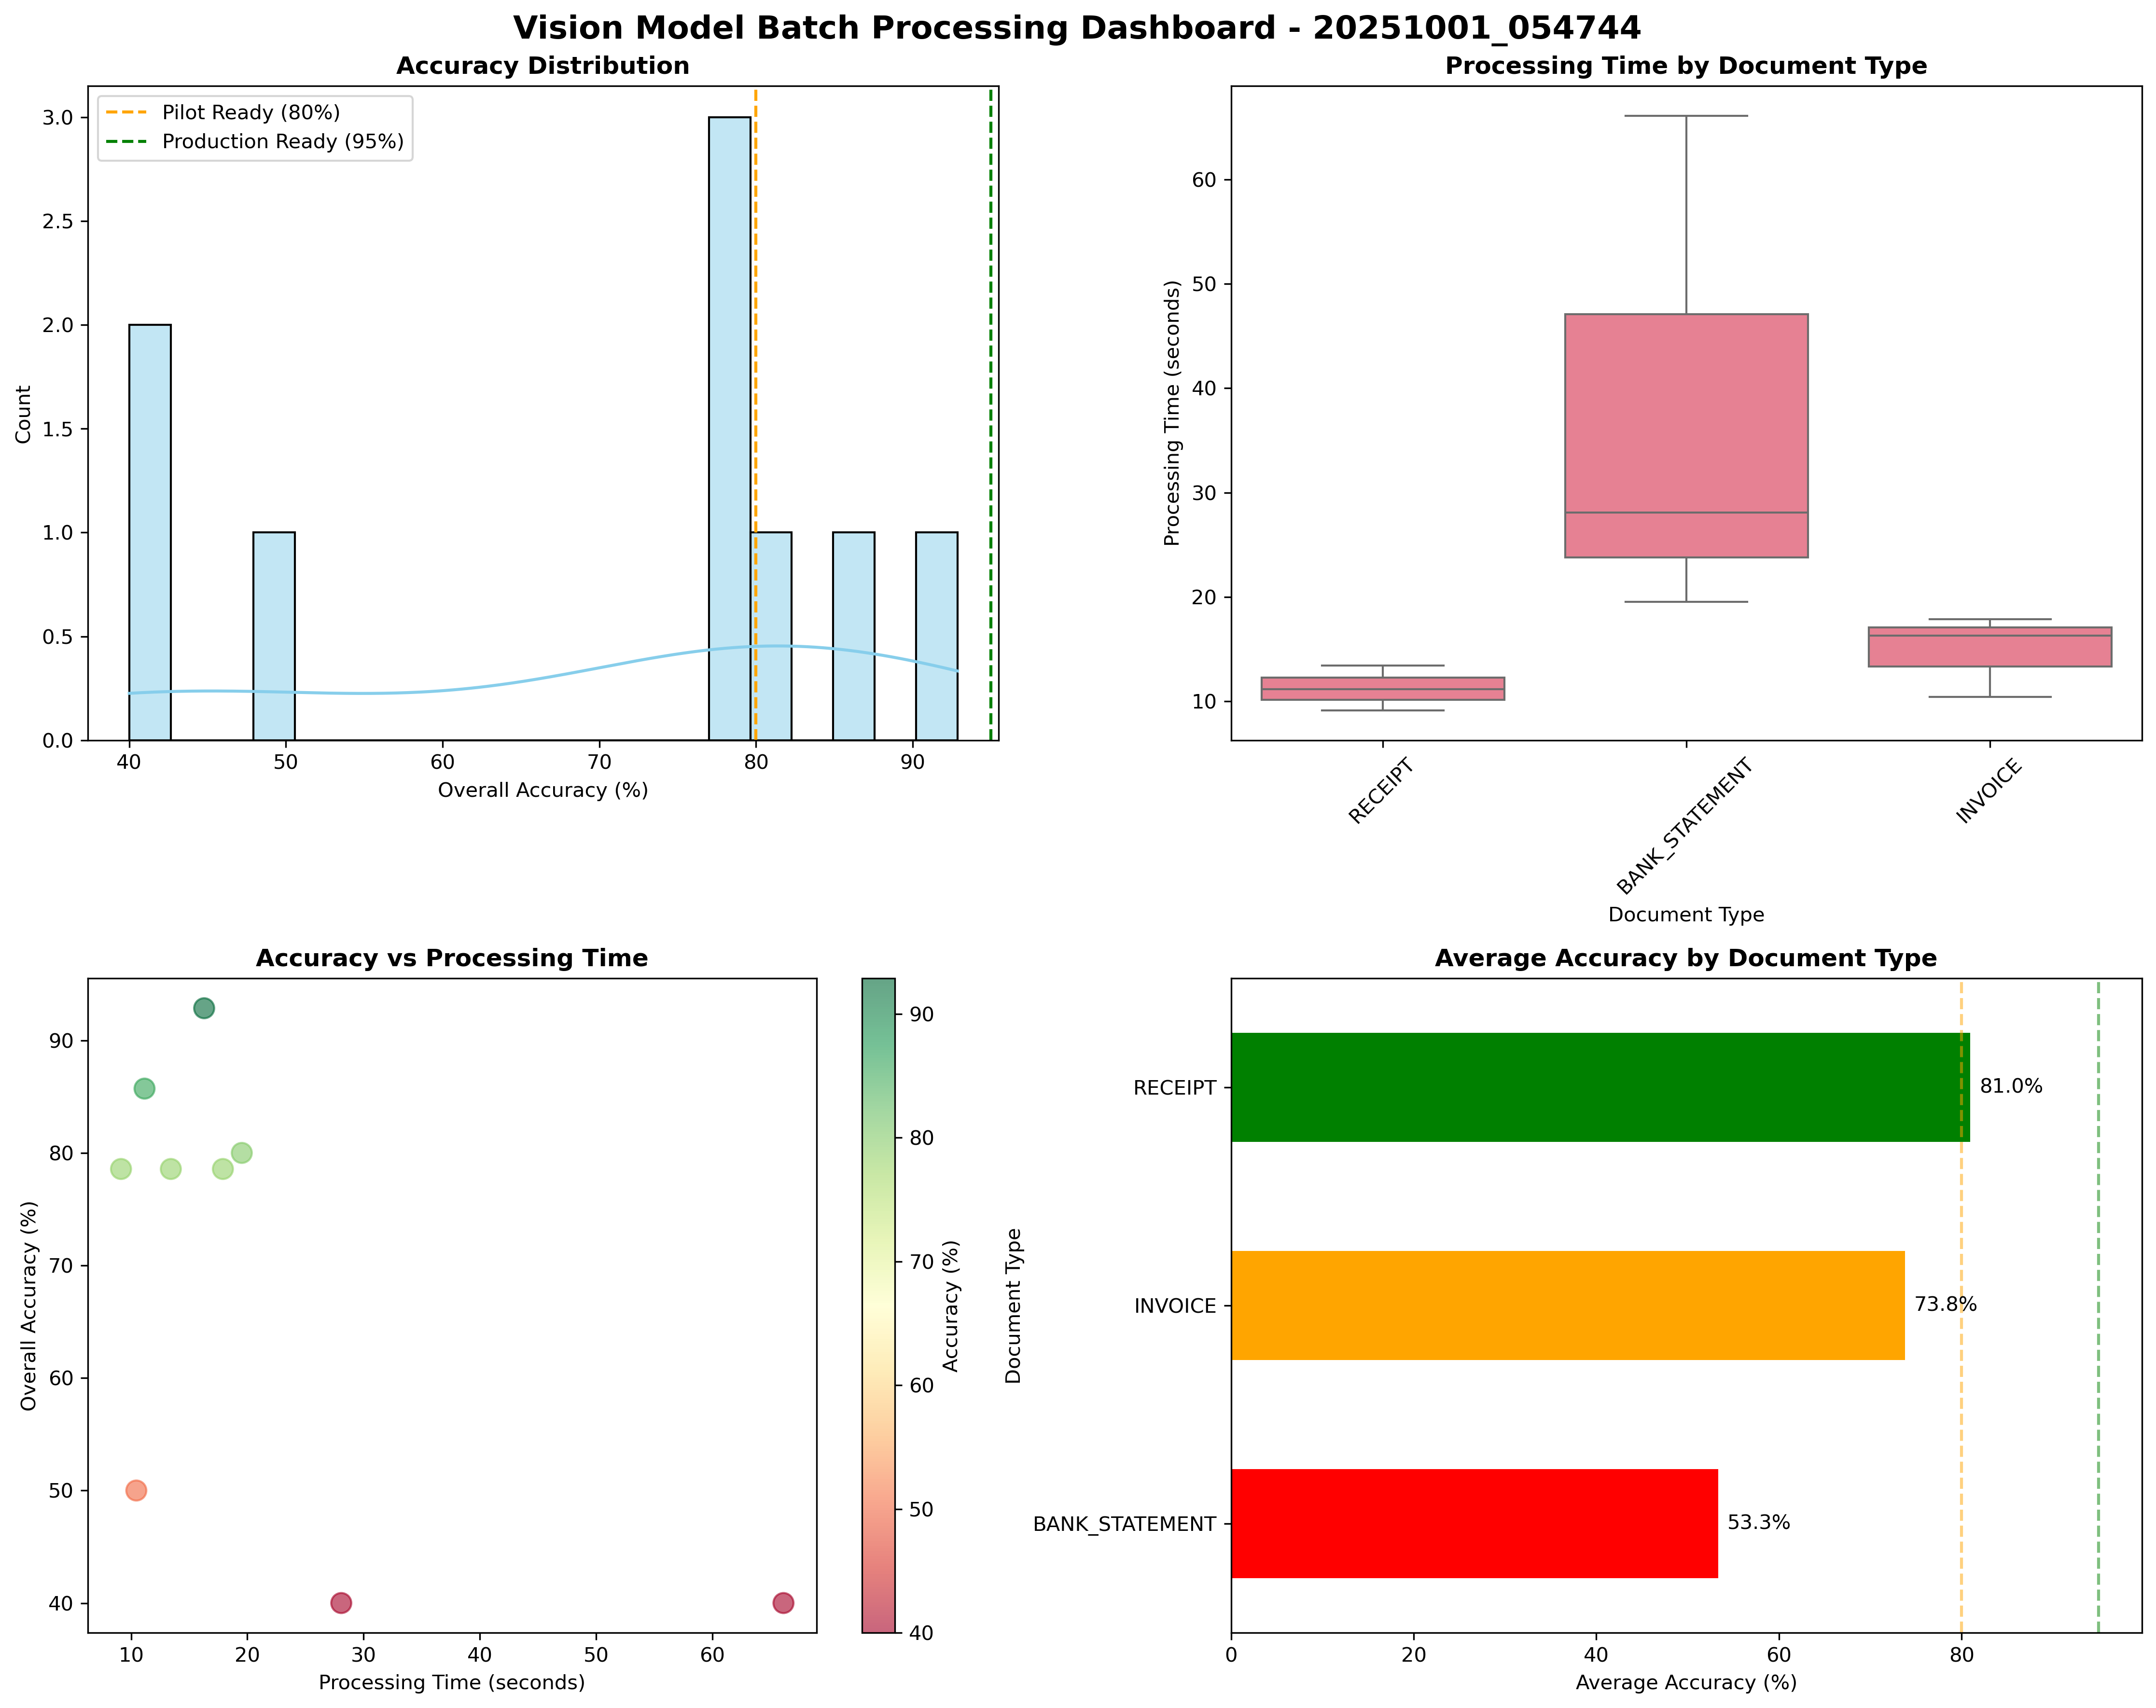

🔬 TESTING CONCLUSION:

Compare these results with the quantized version to determine:

  1. Whether quantization is still necessary for V100

  2. Performance differences between quantized/non-quantized modes

  3. Whether the bug fixes resolved the underlying issues

In [12]:
# Display final summary
console.rule("[bold green]InternVL3 NON-QUANTIZED Batch Processing Complete[/bold green]")

total_images = len(batch_results)
successful = len([r for r in batch_results if 'error' not in r])
avg_accuracy = df_results['overall_accuracy'].mean() if len(df_results) > 0 else 0

rprint(f"[bold green]✅ Processed: {total_images} images[/bold green]")
rprint(f"[cyan]Success Rate: {(successful/total_images*100):.1f}%[/cyan]")
rprint(f"[cyan]Average Accuracy: {avg_accuracy:.2f}%[/cyan]")
rprint(f"[cyan]Output: {OUTPUT_BASE}[/cyan]")
rprint("[yellow]🔬 QUANTIZATION: DISABLED (testing non-quantized performance)[/yellow]")

# Performance assessment
if successful == total_images and avg_accuracy > 50:  # Reasonable thresholds
    rprint("\n[bold green]🎉 SUCCESS: Non-quantized InternVL3 appears to be working correctly![/bold green]")
    rprint("[green]✅ This proves the bug fixes (Rich recursion, prompt repetition) resolved the core issues[/green]")
    rprint("[green]✅ InternVL3-2B can run without quantization as it did before the problems emerged[/green]")
elif successful < total_images:
    rprint("\n[bold red]❌ FAILURE: Processing errors occurred[/bold red]")
    rprint("[red]🔍 This suggests quantization may still be required for stability[/red]")
elif avg_accuracy < 30:  # Very low accuracy threshold
    rprint("\n[bold yellow]⚠️ POOR PERFORMANCE: Very low accuracy detected[/bold yellow]")
    rprint("[yellow]🔍 Check if responses contain gibberish - may indicate quantization still needed[/yellow]")
else:
    rprint("\n[bold blue]📊 MIXED RESULTS: Partially working[/bold blue]")
    rprint("[blue]🔍 Review individual results to assess response quality[/blue]")

# Document type distribution
if document_types_found:
    rprint("\n[bold blue]📋 Document Type Distribution:[/bold blue]")
    for doc_type, count in document_types_found.items():
        percentage = (count / total_images * 100) if total_images > 0 else 0
        rprint(f"[cyan]  {doc_type}: {count} documents ({percentage:.1f}%)[/cyan]")

# Display dashboard if available
dashboard_files = list(OUTPUT_DIRS['visualizations'].glob(f"dashboard_{BATCH_TIMESTAMP}.png"))
if dashboard_files:
    from IPython.display import Image, display
    dashboard_path = dashboard_files[0]
    rprint("\n[bold blue]📊 Visual Dashboard:[/bold blue]")
    display(Image(str(dashboard_path)))
else:
    rprint(f"\n[yellow]⚠️ Dashboard not found in {OUTPUT_DIRS['visualizations']}[/yellow]")

rprint("\n[bold blue]🔬 TESTING CONCLUSION:[/bold blue]")
rprint("[blue]Compare these results with the quantized version to determine:[/blue]")
rprint("[blue]  1. Whether quantization is still necessary for V100[/blue]")
rprint("[blue]  2. Performance differences between quantized/non-quantized modes[/blue]")
rprint("[blue]  3. Whether the bug fixes resolved the underlying issues[/blue]")

In [ ]:
# Calculate zero accuracy extractions
zero_accuracy_count = 0
zero_accuracy_images = []
total_evaluated = 0

for result in batch_results:
    # Check if evaluation data exists (not inference-only mode)
    evaluation = result.get("evaluation", {})

    if evaluation and not evaluation.get("inference_only", False):
        total_evaluated += 1
        accuracy = evaluation.get("overall_accuracy", 0)

        if accuracy == 0.0:
            zero_accuracy_count += 1
            zero_accuracy_images.append(
                {
                    "image_name": result.get("image_name", "unknown"),
                    "document_type": result.get("document_type", "unknown"),
                    "fields_extracted": evaluation.get("fields_extracted", 0),
                    "total_fields": evaluation.get("total_fields", 0),
                }
            )

# Display results
if total_evaluated > 0:
    console.rule("[bold red]Zero Accuracy Analysis[/bold red]")

    rprint(f"[cyan]Total documents evaluated: {total_evaluated}[/cyan]")
    rprint(f"[red]Documents with 0% accuracy: {zero_accuracy_count}[/red]")

    if zero_accuracy_count > 0:
        percentage = (zero_accuracy_count / total_evaluated) * 100
        rprint(f"[red]Zero accuracy rate: {percentage:.1f}%[/red]")

        rprint("\n[bold red]Documents with 0% Accuracy:[/bold red]")
        for i, img_info in enumerate(zero_accuracy_images, 1):
            rprint(f"  {i}. {img_info['image_name']} ({img_info['document_type']})")
            rprint(
                f"     Fields extracted: {img_info['fields_extracted']}/{img_info['total_fields']}"
            )
    else:
        rprint(
            "[green]✅ No documents with 0% accuracy - all extractions had some success![/green]"
        )
else:
    rprint(
        "[yellow]⚠️ Running in inference-only mode - no accuracy metrics available[/yellow]"
    )
